# Stabl per-fold feature selection

## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from src.moe_stabl_baseline.stabl_proxy import select_stabl_features, stabl_preprocessor

## Set up

In [2]:
path_to_gdpa1 = "../../data/GDPa1_v1.2_20250814.csv"
df_gdpa1 = pd.read_csv(path_to_gdpa1)

path_to_moe_features = "../../data/features/processed_features/GDPa1/MOE_properties.csv"
df_moe_features = pd.read_csv(path_to_moe_features)

df_merged = df_gdpa1.merge(df_moe_features, on="antibody_name", how="left")

PROPERTIES = ["HIC", "Titer", "PR_CHO", "AC-SINS_pH7.4", "Tm2"]
df_targets = df_merged[["antibody_name"] + PROPERTIES]

FOLD_MODES = ["all", 0, 1, 2, 3, 4]
fold_label = "hierarchical_cluster_IgG_isotype_stratified_fold"
df_folds = df_merged[["antibody_name", fold_label]]

moe_features_intersect_merged = [col for col in df_moe_features.columns if col in df_merged.columns]
df_merged = df_merged[moe_features_intersect_merged]
df_merged = df_merged.drop(columns=["mseq"], errors="ignore")

df_merged = df_merged.set_index("antibody_name")
df_targets = df_targets.set_index("antibody_name")
df_folds = df_folds.set_index("antibody_name")

In [3]:
PARAMS_STABL = {
    "n_bootstraps":500,
    "fraction":1.0,
    "variance_threshold":0.0,
    "scale":True,
    "n_jobs":-1,
    "fdp_grid_size":1001,
    "alpha_grid":np.linspace(0.01, 1.0, 100),
    "max_iter":1000,
}

seed = 42

## Visualization Helpers

In [21]:
def plot_fdp(fdp_info, title = None):
    plt.figure(figsize=(8,6))
    fdp = fdp_info["fdp"]
    t = fdp_info["t"]
    thr_opt = fdp_info["thr_opt"]
    plt.plot(t, fdp, label="Estimated FDP")
    plt.axvline(x=thr_opt, color="red", linestyle="--", label="Optimal threshold "+f"({thr_opt:.2f})")
    if title is not None:
        plt.title(title)
    plt.xlabel("Selection threshold")
    plt.ylabel("Estimated FDP")
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

def plot_per_feature_freq(merged_freqs, selected_features, thr_opt, title = None):
    plt.figure(figsize=(8,6))
    for feature, data in merged_freqs.items():
        if "artificial" in feature:
            continue
        inv_alpha = data["1/alpha"]
        freq = data["freq"]
        if feature in selected_features:
            plt.plot(inv_alpha, freq, label=feature, linewidth=1., color = "darkred")
        else:
            plt.plot(inv_alpha, freq, linewidth=0.5, color = "lightgray")
    if title is not None:
        plt.title(title)
    plt.xlabel("1/alpha")
    plt.ylabel("Selection frequency")
    plt.legend()
    plt.axhline(y=thr_opt, color="red", linestyle="--", label="Optimal threshold ")
    plt.ylim(0, 1)
    plt.show()


## Feature selection over all MOE features

In [8]:
results_dict = {}

for target in PROPERTIES:
    results_dict[target] = {}
    for fold_mode in FOLD_MODES:
        print(f"Processing target: {target}")
        print(f"Processing fold mode: {fold_mode}")
        y = df_targets[[target]]
        if fold_mode == "all":
            mask = y.notna().values.ravel()
        else:
            mask = (df_folds[fold_label] != fold_mode) & y.notna().values.ravel()

        X_train = df_merged.loc[mask]
        y_train = y.loc[mask]

        preproc = stabl_preprocessor(scale=True)
        X_proc = pd.DataFrame(preproc.fit_transform(X_train),
                              columns=X_train.columns, index=X_train.index)

        res = select_stabl_features(
            X_proc, y_train,
            n_bootstraps=PARAMS_STABL["n_bootstraps"],
            fraction=PARAMS_STABL["fraction"],
            alpha_grid=PARAMS_STABL["alpha_grid"],
            max_iter=1000,
            fdp_grid_size=PARAMS_STABL["fdp_grid_size"]
        )

        results_dict[target][fold_mode] = res
        print(f"Selected {len(res['selected_features'])} features for target {target} fold {fold_mode}")
        print("----")

Processing target: HIC
Processing fold mode: all


STABL α-grid: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Selected 17 features for target HIC fold all
----
Processing target: HIC
Processing fold mode: 0


STABL α-grid: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Selected 14 features for target HIC fold 0
----
Processing target: HIC
Processing fold mode: 1


STABL α-grid: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Selected 16 features for target HIC fold 1
----
Processing target: HIC
Processing fold mode: 2


STABL α-grid: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


Selected 17 features for target HIC fold 2
----
Processing target: HIC
Processing fold mode: 3


STABL α-grid: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Selected 17 features for target HIC fold 3
----
Processing target: HIC
Processing fold mode: 4


STABL α-grid: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Selected 19 features for target HIC fold 4
----
Processing target: Titer
Processing fold mode: all


STABL α-grid: 100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Selected 13 features for target Titer fold all
----
Processing target: Titer
Processing fold mode: 0


STABL α-grid: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


Selected 12 features for target Titer fold 0
----
Processing target: Titer
Processing fold mode: 1


STABL α-grid: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


Selected 21 features for target Titer fold 1
----
Processing target: Titer
Processing fold mode: 2


STABL α-grid: 100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


Selected 15 features for target Titer fold 2
----
Processing target: Titer
Processing fold mode: 3


STABL α-grid: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


Selected 12 features for target Titer fold 3
----
Processing target: Titer
Processing fold mode: 4


STABL α-grid: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


Selected 12 features for target Titer fold 4
----
Processing target: PR_CHO
Processing fold mode: all


STABL α-grid: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


Selected 16 features for target PR_CHO fold all
----
Processing target: PR_CHO
Processing fold mode: 0


STABL α-grid: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Selected 19 features for target PR_CHO fold 0
----
Processing target: PR_CHO
Processing fold mode: 1


STABL α-grid: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Selected 18 features for target PR_CHO fold 1
----
Processing target: PR_CHO
Processing fold mode: 2


STABL α-grid: 100%|██████████| 100/100 [00:53<00:00,  1.85it/s]


Selected 17 features for target PR_CHO fold 2
----
Processing target: PR_CHO
Processing fold mode: 3


STABL α-grid: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Selected 20 features for target PR_CHO fold 3
----
Processing target: PR_CHO
Processing fold mode: 4


STABL α-grid: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Selected 15 features for target PR_CHO fold 4
----
Processing target: AC-SINS_pH7.4
Processing fold mode: all


STABL α-grid: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Selected 11 features for target AC-SINS_pH7.4 fold all
----
Processing target: AC-SINS_pH7.4
Processing fold mode: 0


STABL α-grid: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Selected 13 features for target AC-SINS_pH7.4 fold 0
----
Processing target: AC-SINS_pH7.4
Processing fold mode: 1


STABL α-grid: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Selected 6 features for target AC-SINS_pH7.4 fold 1
----
Processing target: AC-SINS_pH7.4
Processing fold mode: 2


STABL α-grid: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Selected 8 features for target AC-SINS_pH7.4 fold 2
----
Processing target: AC-SINS_pH7.4
Processing fold mode: 3


STABL α-grid: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Selected 10 features for target AC-SINS_pH7.4 fold 3
----
Processing target: AC-SINS_pH7.4
Processing fold mode: 4


STABL α-grid: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Selected 12 features for target AC-SINS_pH7.4 fold 4
----
Processing target: Tm2
Processing fold mode: all


STABL α-grid: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Selected 3 features for target Tm2 fold all
----
Processing target: Tm2
Processing fold mode: 0


STABL α-grid: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Selected 5 features for target Tm2 fold 0
----
Processing target: Tm2
Processing fold mode: 1


STABL α-grid: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Selected 7 features for target Tm2 fold 1
----
Processing target: Tm2
Processing fold mode: 2


STABL α-grid: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Selected 4 features for target Tm2 fold 2
----
Processing target: Tm2
Processing fold mode: 3


STABL α-grid: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Selected 6 features for target Tm2 fold 3
----
Processing target: Tm2
Processing fold mode: 4


STABL α-grid: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]

Selected 5 features for target Tm2 fold 4
----


In [9]:
# save results to pkl file
with open("stabl_feature_selection_results.pkl", "wb") as f:
    pickle.dump(results_dict, f)

## Diagnostic plots

How many features selected over each complete dataset run? 

In [13]:
for target in PROPERTIES:
    print(len(results_dict[target]["all"]["selected_features"]), f"features selected for target {target} fold all")

17 features selected for target HIC fold all
13 features selected for target Titer fold all
16 features selected for target PR_CHO fold all
11 features selected for target AC-SINS_pH7.4 fold all
3 features selected for target Tm2 fold all


Plotting False discovery proportion as a function of the feature frequency selection threshold. Well behaved FDP plots will exhibit a minimum that we use for feature selection. 

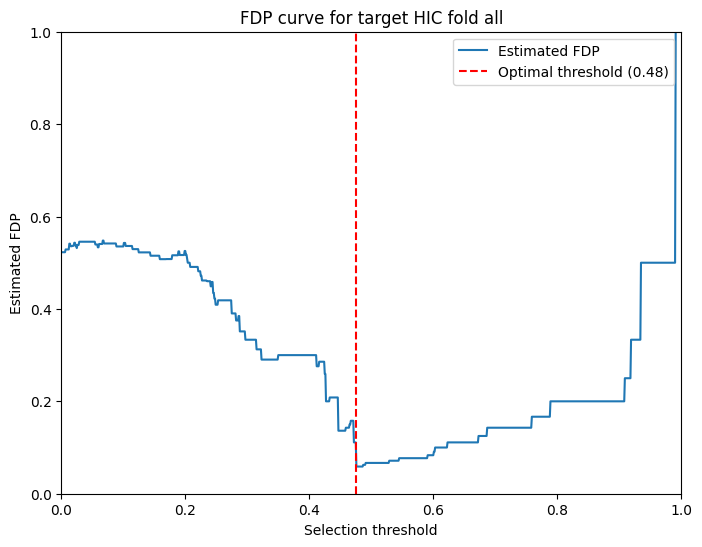

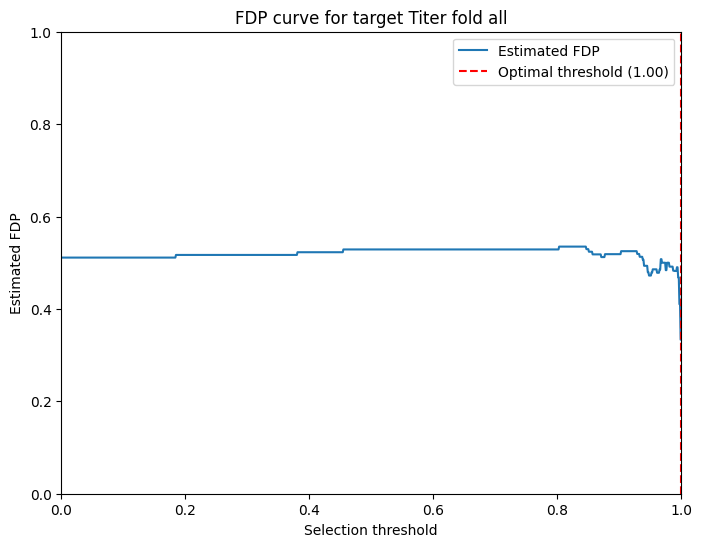

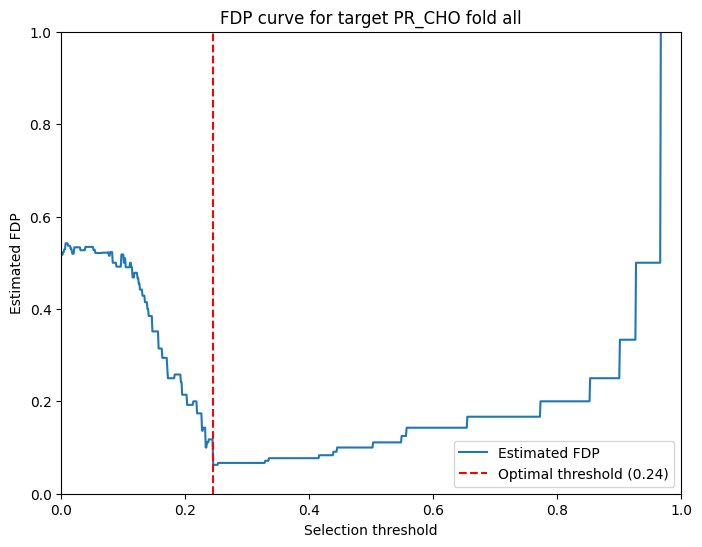

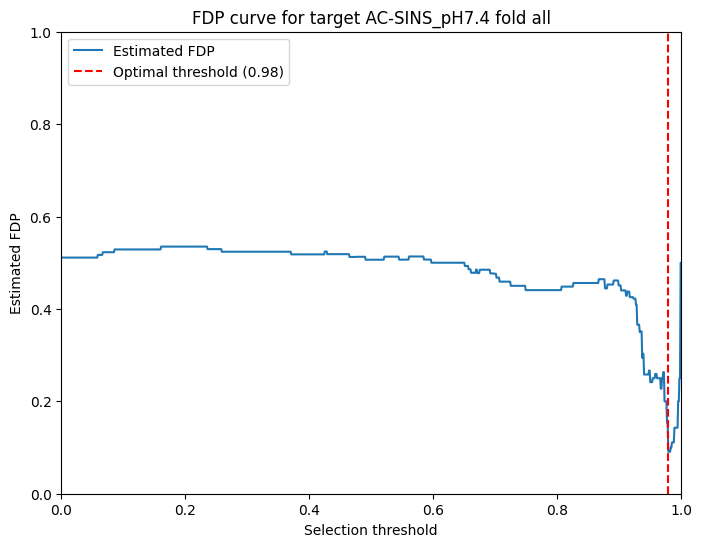

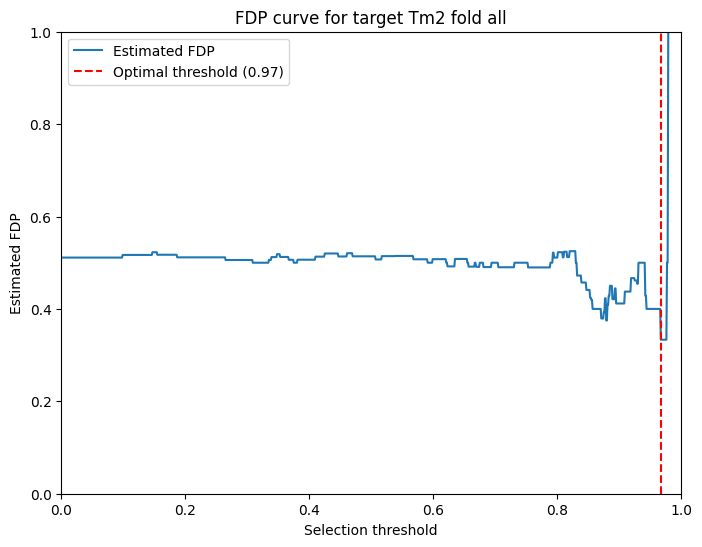

In [22]:
for target in PROPERTIES: 
    plot_fdp(results_dict[target]["all"]["fdp_info"], title=f"FDP curve for target {target} fold all")

Newt, we plot the **Stability paths**: each feature Lasso frequency over the range of $1/\alpha$ (Lasso hyper-parameter value). Features with a dark red color cross the optimal threshold for feature selection. 

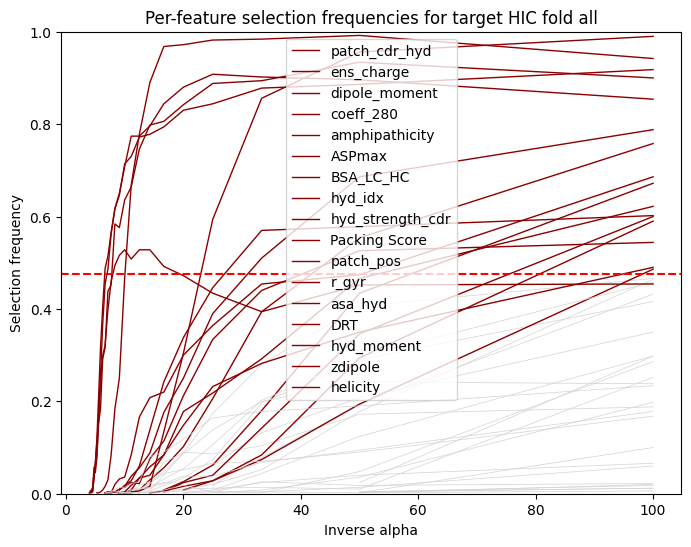

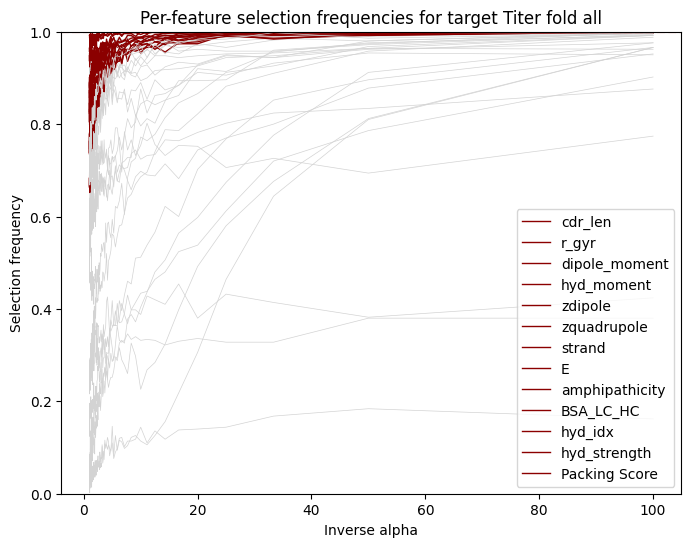

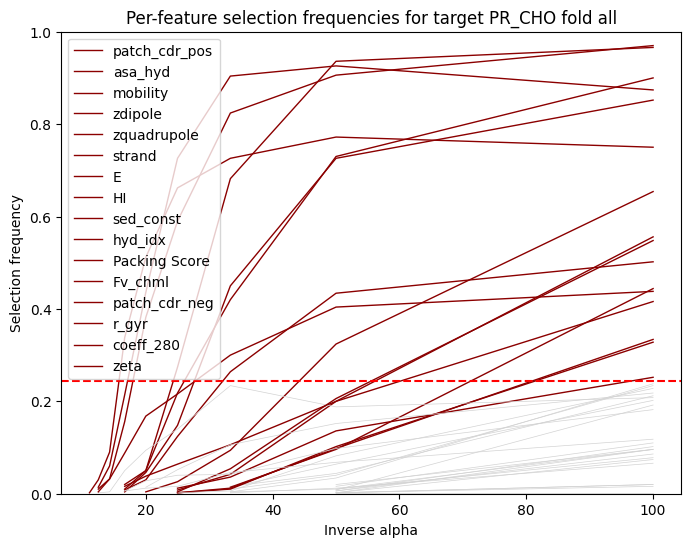

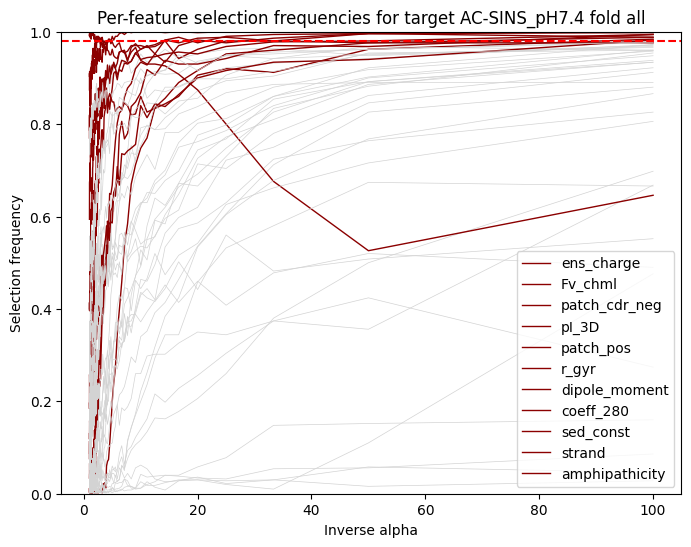

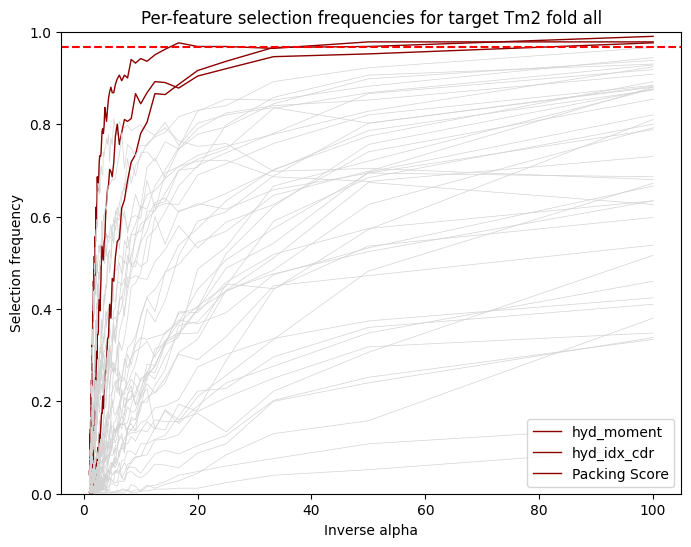

In [18]:
for target in PROPERTIES:
    plot_per_feature_freq(
        results_dict[target]["all"]["merged_freq"],
        results_dict[target]["all"]["selected_features"],
        results_dict[target]["all"]["fdp_info"]["thr_opt"],
        title=f"Per-feature selection frequencies for target {target} fold all"
    )

## Conclusions

Stabl-selected features for each target (after training Stabl over the entire train set): 
> * **HIC** (17): patch_cdr_hyd, ens_charge, dipole_moment, coeff_280, amphipathicity, ASPmax, BSA_LC_HC, hyd_idx, hyd_strength_cdr, Packing Score, patch_pos, r_gyr, asa_hyd, DRT, , hyd_moment, zdipole, helicity. 
>
> * **PR_CHO** (16): patch_cdr_pos, asa_hyd, mobility, zdipole, zquadrupole, strand, E, HI, sed_const, hyd_idx, Packing Score, Fv_chml, patch_cdr_neg, r_gyr, coeff_280, zeta. 
> 
> * **Titer** (13): cdr_len, r_gyr, dipole_moment, hyd_moment, zdipole, zquadrupole, strand, E, amphipathicity, BSA_LC_HC, hyd_idx, hyd_strength, Packing Score.
> 
> * **AC-SINS_pH7.4** (11): ens_charge, Fv_chml, patch_cdr_neg, pI_3D, patch_pos, r_gyr, dipole_moment, coeff_280, sed_const, strand, amphipathicity. 
> 
> * **Tm2** (3): hyd_moment, hyd_idx_cdr, Packing Score. 

Most selected features are: 
> * **Packing Score**: HIC, PR_CHO, Titer, Tm2
> 
> * **r_gyr**: HIC, PR_CHO, Titer, AC-SINS_pH7.4
> 
> * **dipole_moment**: HIC, Titer, AC-SINS_pH7.4
> 
> * **coeff_280**: HIC, PR_CHO, AC-SINS_pH7.4
> 
> * **amphipathicity**: HIC, PR_CHO, AC-SINS_pH7.4
> 
> * **hyd_moment**: HIC, Titer, Tm2
> 
> * **zdipole**: HIC, PR_CHO, Titer
> 
> * **strand**: PR_CHO, Titer, AC-SINS_pH7.4

Overall, all targets except Titer exhibit a plausible optimal threshold that minimizes FDP in $(0,1)$. For Titer, we see that the optimal threshold is equal to $1$, which still allows to select 13 features over the entire training set. This threshold however doesn't look quite reliable, so we suggest using the entire set of features in that case.  